# Deep Learning Final Project

CSC 375  
Frank Fang & Eva Wu

## Preparing the Dataset

The dataset we are using is a audio classification dataset with originally 8 classes. Within each class, about a thousand 2 seconds audio file was used as training data and 500 each class as testing data. Due to the imbalance of class 'Junk'(too large) and class 'tingut' (too small), we decide to not include those two classes. Thus, in this project, we are doing a multiclass classification for 6 classes.

We've tried to do 8 classes at first, however, due to the too large class 'Junk', the prediction easily became all towards that class, which makes the training impossible.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

In [183]:
# set the downsample threshold
numOfsr = 2000

In [3]:
#import the training data from local folder
import librosa
DataDir = "WFU_Dataset/train_WFU"
Categories = ["crybar", "crycin", "crystr", "cryund", "cryvar", "tinmaj"]
##"junk", "tingut",
from tqdm import tqdm
import wave
import tensorflow as tf
import tensorflow_io as tfio
training_data1 = []

# label training data by which folder its in
for category in Categories: 
    path = os.path.join(DataDir,category)
    class_num = Categories.index(category)
    
    for wav in tqdm(os.listdir(path)):  # iterate over each sound waves
        #wav_array = wave.open(os.path.join(path,wav), 'rb')# convert to array
        wav_array, sr = librosa.load(os.path.join(path,wav), numOfsr)
        if (wav_array.shape[0] == 4000):
            training_data1.append([wav_array, class_num])
        #wav_array.close()

/home/csuser/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
100%|██████████| 1352/1352 [00:35<00:00, 37.71it/s]


In [4]:
#display a sample of the training data

import random
randnum = random.randint(0, len(training_data1)-1)
exampleWav = training_data1[randnum][0][:]

audio_tensor = exampleWav
print(audio_tensor)

[ 0.00035524  0.00116597  0.00054285 ... -0.00165742 -0.00201104
  0.00126211]


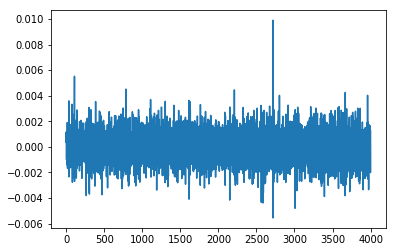

In [5]:
import matplotlib.pyplot as plt
#display the wav plot of the sample

tensor = tf.cast(audio_tensor, tf.float32)

plt.figure()
plt.plot(tensor.numpy())

In [6]:
import random

random.shuffle(training_data1)

In [7]:
X_train = []
y_train = []
#seperate train data and train label
for features, label in training_data1:
    if len(features) != 4000:
        continue
    X_train.append(features)
    y_train.append(label)

In [8]:
DataDir = "WFU_Dataset/test_WFU"
Categories = ["crybar", "crycin", "crystr", "cryund", "cryvar",  "tinmaj"]
#"junk", "tingut",
#create testing data
testing_data = []

for category in Categories: 
    path = os.path.join(DataDir,category)
    class_num = Categories.index(category)
    
    for wav in tqdm(os.listdir(path)):  # iterate over each sound waves
        #wav_array = wave.open(os.path.join(path,wav), 'rb')# convert to array
        wav_array, sr = librosa.load(os.path.join(path,wav), sr = numOfsr)
        if (wav_array.shape[0] == 4000):
            testing_data.append([wav_array, class_num])
        #wav_array.close()

100%|██████████| 580/580 [00:15<00:00, 37.77it/s]


In [9]:
random.shuffle(testing_data)

X_test = []
y_test = []

for features, label in testing_data:
    if len(features) != 4000:
        print(len(X_test))
    X_test.append(features)
    y_test.append(label)

In [10]:
X_train = np.asarray(X_train)
X_test =  np.asarray(X_test)
y_train = np.asarray(y_train)
y_test= np.asarray(y_test)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7966, 4000)
(7966,)
(3415, 4000)
(3415,)


In [12]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X_train, y_train):
    X_train_new, X_val, y_train_new, y_val = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    
X_train = X_train_new
y_train = y_train_new
print("The number of training data : ", len(X_train))
print("The number of validation data : ", len(X_val))

The number of training data :  6372
The number of validation data :  1594


In [13]:
def to_one_hot(labels, dimension=6):
# 8
    results = np.zeros((len(labels), dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results

y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(6372, 6)
(1594, 6)
(3415, 6)


# Baseline Model

In this intial model, we train a simple CNN for audio WAVE from scratch. It's not an accurate model, and the biggest problem is that audio wave is sort of a sequential data, and CNN is not good at dealing with 1D sequential data. 

In [14]:
from keras import models
from keras import layers
from keras import optimizers

In [15]:
from keras.layers import Embedding, SimpleRNN

model = models.Sequential()
#model.add(Embedding(10000, 32))
#model.add(SimpleRNN(32))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dense(8, activation='softmax'))
model.add(layers.Dense(6, activation='softmax'))


In [16]:
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs = 30,
                    batch_size = 64,
                    validation_data=(X_val,y_val))

Epoch 1/30
100/100 [==============================] - 0s 4ms/step - loss: 1.7899 - accuracy: 0.1944 - val_loss: 1.7884 - val_accuracy: 0.2334
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 1.7624 - accuracy: 0.2767 - val_loss: 1.7813 - val_accuracy: 0.2146
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 1.6865 - accuracy: 0.3738 - val_loss: 1.7772 - val_accuracy: 0.2240
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 1.5746 - accuracy: 0.4426 - val_loss: 1.7869 - val_accuracy: 0.1913
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 1.4541 - accuracy: 0.4906 - val_loss: 1.8278 - val_accuracy: 0.2171
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 1.3315 - accuracy: 0.5507 - val_loss: 1.8866 - val_accuracy: 0.1895
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 1.2128 - accuracy: 0.5942 - val_loss: 1.9639 - val_accuracy: 0.2045
Epoch 

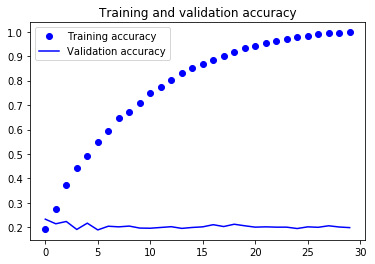

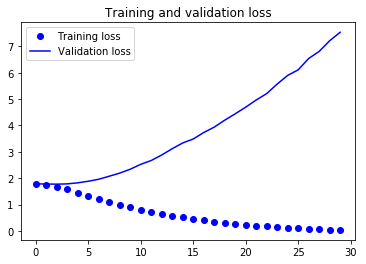

In [17]:

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### ConfusionMatrix Visualization

We implement the confusion matrix as the visualization in this project to comparing models and to visualize the improvment. The diagonal represent the target training outcome that the prediction matched the true label. As we can see from this model, it barely beats the accuracy just by chance (17.5%). Although this is a awful model to do audio classification, it points out that if we are going to use CNN to train audio waves, we need to make it a 2d image that CNN can takes in and train properly.

Test set accuracy: 20%


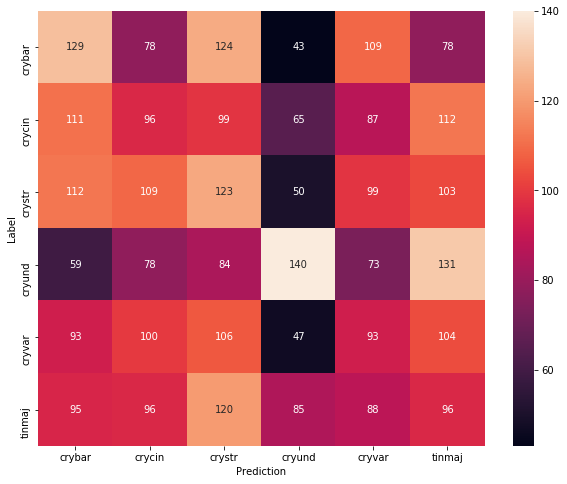

In [18]:
y_test_new = []

for features, label in testing_data:
    if len(features) != 4000:
        continue
    y_test_new.append(label)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test_new

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

#print(y_true[:100])
#print(y_pred[:1000])

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=Categories, yticklabels=Categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Simple CNN with Spectrogram


A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.
A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

The vertical axis shows frequencies (from 0 to 12kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

In [19]:
# function to transform a wave to a spectrogram
def get_spectrogram(waveform):
  waveform = tf.cast(waveform, tf.float32)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [20]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(4000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [21]:
def transform_spectrogram(audio):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram

In [184]:
import librosa
audio_data = 'WFU_Dataset/train_WFU/crybar/1_00011.wav'
librosa.load(audio_data)

(array([ 0.02287169, -0.00313229, -0.01398074, ..., -0.00847826,
        -0.00858464, -0.00608346], dtype=float32),
 22050)

In [185]:
import IPython.display as ipd
ipd.Audio(audio_data)

This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono. We can change this behavior by resampling at 44.1KHz, or we can downsample to to 4 KHz.

In [24]:
x, sr = librosa.load(audio_data, sr=2000)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(4000,) 2000


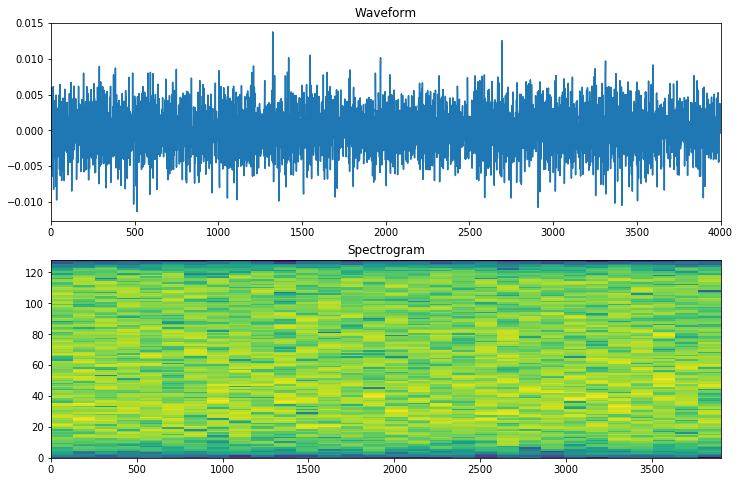

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(x.shape[0])
axes[0].plot(timescale, x)
axes[0].set_title('Waveform')
axes[0].set_xlim([0,4000])
plot_spectrogram(get_spectrogram(x).numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [26]:
X_train = transform_spectrogram(X_train)

In [27]:
X_train.shape

TensorShape([6372, 30, 129, 1])

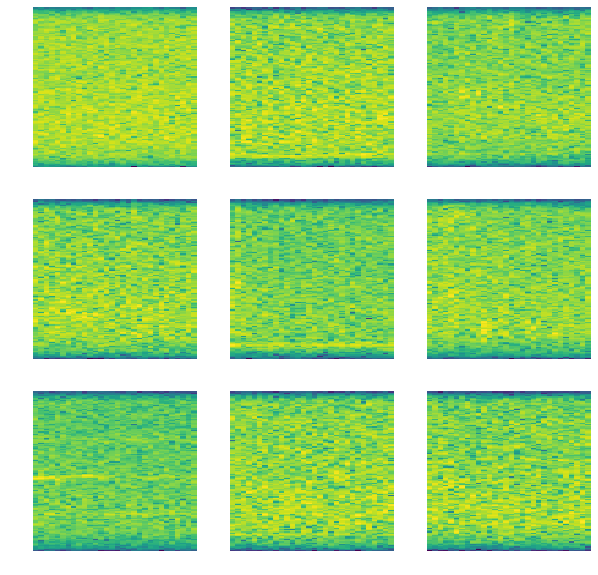

In [28]:
## display first 9 spectrogram to make sure the training data is transformed properly

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, spectrogram in enumerate(X_train[:9]):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram), ax)
  ax.axis('off')

plt.show()

In [29]:
## transform the validation set and test set to spectrogram as well

X_val=transform_spectrogram(X_val)
X_test=transform_spectrogram(X_test)

In [30]:
from tensorflow.keras.layers.experimental import preprocessing

input_shape = X_train[0].shape
print('Input shape:', input_shape)

#norm_layer = preprocessing.Normalization()
#norm_layer.adapt(X_train.map(lambda x: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    #norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(8, activation = 'softmax')
    layers.Dense(6, activation = 'softmax')
])

model.summary()

Input shape: (30, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                7372832   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 7,448,102
Trainable params: 7,448,102
Non-trainable params: 0
__________________

In [31]:
model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train,y_train,epochs = 30,
                    batch_size = 64,
                    validation_data=(X_val,y_val))

Epoch 1/30
100/100 [==============================] - 4s 35ms/step - loss: 1.6867 - accuracy: 0.2848 - val_loss: 1.6008 - val_accuracy: 0.3601
Epoch 2/30
100/100 [==============================] - 3s 32ms/step - loss: 1.5471 - accuracy: 0.3570 - val_loss: 1.4913 - val_accuracy: 0.3683
Epoch 3/30
100/100 [==============================] - 3s 32ms/step - loss: 1.4228 - accuracy: 0.4251 - val_loss: 1.4906 - val_accuracy: 0.4335
Epoch 4/30
100/100 [==============================] - 3s 32ms/step - loss: 1.2738 - accuracy: 0.5019 - val_loss: 1.5475 - val_accuracy: 0.4072
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 1.1215 - accuracy: 0.5640 - val_loss: 1.6270 - val_accuracy: 0.4065
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 0.9751 - accuracy: 0.6230 - val_loss: 1.7602 - val_accuracy: 0.4272
Epoch 7/30
100/100 [==============================] - 3s 32ms/step - loss: 0.8185 - accuracy: 0.6901 - val_loss: 1.9705 - val_accuracy: 0.3984

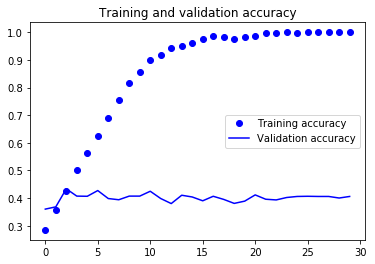

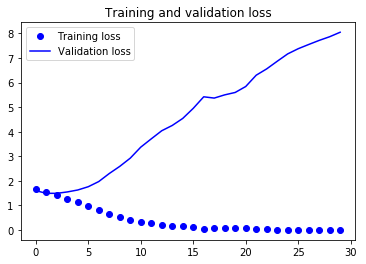

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Simple CNN with Spectrogram Conclusion
As the following confusion matrix compare to the previous one, we can see that the diagonal is more clear and the prediction is better as the accuracy goes up to about 40%. This suggests the significant role of spectrogram in traning audio file with CNN. As they were all transformed to images, Conv2D comes into use and boost the model way up compare to just dense layers.

In [34]:
y_test_new = []

for features, label in testing_data:
    if len(features) != 4000:
        continue
    y_test_new.append(label)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test_new

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 39%


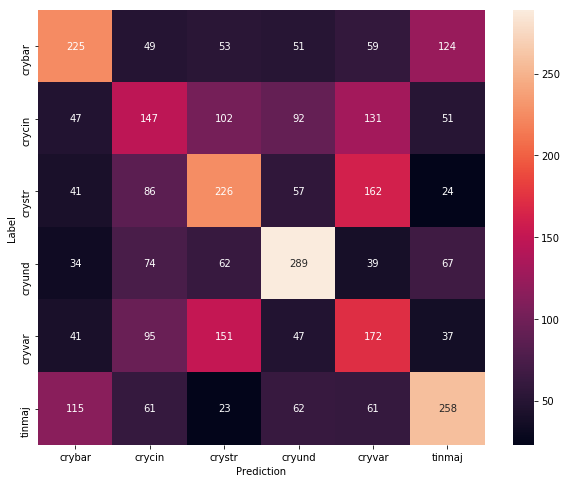

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=Categories, yticklabels=Categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Spectrogram with Transfer Learning

In the following section, we implement transfer learning, specifically VGG 16 to train our spectrogram audio files.

In [36]:
# due to the requirement of the VGG16 input channel size, 
#we repeat the data 3 times to make it RGB channel for grey-scale spectrograms
print(X_train.shape)
X_train = np.repeat(X_train[...], 3,-1)
print(X_train.shape)
X_test = np.repeat(X_test[...], 3,-1)
X_val = np.repeat(X_val[...], 3,-1)

(6372, 30, 129, 1)
(6372, 30, 129, 3)


We tried both DenseNet and VGG16, and decide to use VGG16 in the end due to the time consumption of DenseNet, even just 121 is too much, and also it's not significantly different from VGG 16's result.

In [38]:
from keras.applications import VGG16
from keras.applications import DenseNet121

conv_base = VGG16(
    weights = 'imagenet',
include_top=False,
input_shape=(64,64,3))

dense_base = DenseNet121(
    include_top=False,
    input_shape=(64,64,3)
)

In [39]:
model2 = models.Sequential()
model2.add(preprocessing.Resizing(64, 64))

model2.add(conv_base)
#model2.add(dense_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
#model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(64, activation='relu'))
#model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(32, activation='relu'))
#model2.add(layers.Dropout(0.2))
#model2.add(layers.Dense(8, activation='softmax'))
model2.add(layers.Dense(6, activation='softmax'))


model2.build((None,30,139,3))

print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                

In [40]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model2.trainable_weights))

This is the number of trainable weights before freezing the dense base: 34


### Frozen Layers

We start with all layers from VGG16 frozen, and then tune the hyper parameters in later secion.

In [41]:
conv_base.trainable = False

In [42]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model2.trainable_weights))

This is the number of trainable weights after freezing the dense base: 8


In [43]:
model2.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [44]:
history2 = model2.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    validation_steps=50,
                    verbose = 1
                     )

Epoch 1/50
200/200 [==============================] - 4s 20ms/step - loss: 1.6883 - accuracy: 0.2745 - val_loss: 1.6265 - val_accuracy: 0.2905
Epoch 2/50
200/200 [==============================] - 3s 17ms/step - loss: 1.6117 - accuracy: 0.3139 - val_loss: 1.5918 - val_accuracy: 0.3156
Epoch 3/50
200/200 [==============================] - 3s 17ms/step - loss: 1.5876 - accuracy: 0.3247 - val_loss: 1.5612 - val_accuracy: 0.3344
Epoch 4/50
200/200 [==============================] - 3s 17ms/step - loss: 1.5757 - accuracy: 0.3291 - val_loss: 1.5462 - val_accuracy: 0.3626
Epoch 5/50
200/200 [==============================] - 4s 18ms/step - loss: 1.5502 - accuracy: 0.3454 - val_loss: 1.5302 - val_accuracy: 0.3664
Epoch 6/50
200/200 [==============================] - 4s 18ms/step - loss: 1.5375 - accuracy: 0.3525 - val_loss: 1.5213 - val_accuracy: 0.3595
Epoch 7/50
200/200 [==============================] - 4s 18ms/step - loss: 1.5275 - accuracy: 0.3614 - val_loss: 1.5628 - val_accuracy: 0.3438

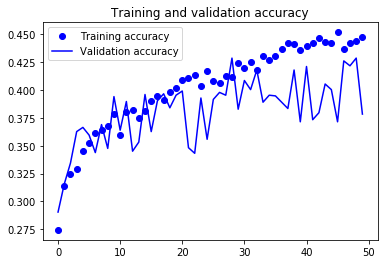

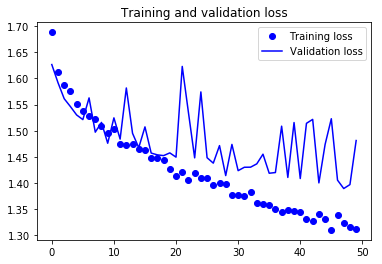

In [45]:
import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Tuning

The transfer learning model is not too much better than previous no transfer learning one is because, first of all, VGG is for image training, but the pre-trained weight, if use ImageNet, it's for object classification mainly, which does not help audio spectrograms a lot. If don't use the pre-trained weight from ImageNet, it's merely just randomed weights. Secondly, the information is highly reduced in the image since we downsampled from 44kHz to 4kHz, which limits the ceiling of the model's accuracy on what it can get. Thirdly, since we froze all layers in the conv_base in the previous model, no Conv_2D layers has been customized with the current data then, which makes the trainable weights only 8. In the following section, we try to hypertuning by defreezing some blocks of the layers to see whether it can get better.

In [47]:
#dense_base.trainable = True
conv_base.trainable = True
set_trainable = False
#for layer in dense_base.layers:
for layer in conv_base.layers:
    #if layer.name == 'conv5_block1_0_bn':
    if layer.name == 'block2_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [48]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model2.trainable_weights))

This is the number of trainable weights after freezing the dense base: 30


In [49]:
model2.compile(optimizer = optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:

history3 = model2.fit(X_train,y_train,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    validation_steps= 50,
                    verbose = 1
                     )

Epoch 1/50
200/200 [==============================] - 10s 50ms/step - loss: 1.7066 - accuracy: 0.3136 - val_loss: 2.2327 - val_accuracy: 0.2409
Epoch 2/50
200/200 [==============================] - 10s 49ms/step - loss: 1.5036 - accuracy: 0.3745 - val_loss: 1.5285 - val_accuracy: 0.3708
Epoch 3/50
200/200 [==============================] - 10s 49ms/step - loss: 1.4298 - accuracy: 0.4080 - val_loss: 1.4807 - val_accuracy: 0.4210
Epoch 4/50
200/200 [==============================] - 10s 49ms/step - loss: 1.3789 - accuracy: 0.4272 - val_loss: 1.5897 - val_accuracy: 0.3726
Epoch 5/50
200/200 [==============================] - 10s 49ms/step - loss: 1.3505 - accuracy: 0.4437 - val_loss: 1.7905 - val_accuracy: 0.2842
Epoch 6/50
200/200 [==============================] - 10s 49ms/step - loss: 1.3255 - accuracy: 0.4543 - val_loss: 1.4728 - val_accuracy: 0.3871
Epoch 7/50
200/200 [==============================] - 10s 49ms/step - loss: 1.3007 - accuracy: 0.4550 - val_loss: 1.6524 - val_accuracy:

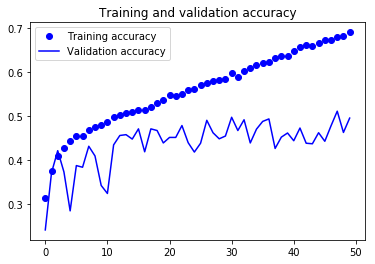

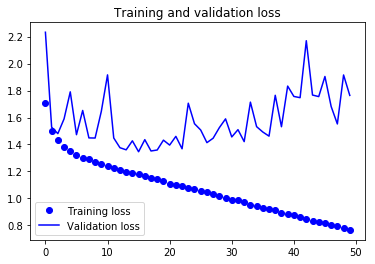

In [51]:
import matplotlib.pyplot as plt

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Test set accuracy: 50%


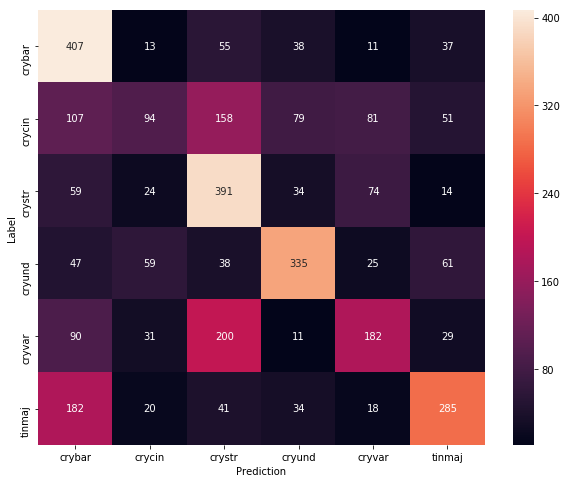

In [52]:
y_test_new = []
#X_test_new = []
for features, label in testing_data:
    if len(features) != 4000:
        continue
   # X_test_new.append(features)
    y_test_new.append(label)

y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = y_test_new

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=Categories, yticklabels=Categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Conclusion

The final model with tuned transfer learning gets to a accuracy about 50% for validation, and also a 50% accuracy of predicting the testing set. Compare to previous models, this is best in terms of both accuracy and loss. 
Due to our downsampling to about 1/10 of size, it's an acceptable level of accuracy. If using the whole data for training, the performance of the model can definitely gets way better than this.
As the confusion matrix suggest, among all six classes we trained and predicted, crystr and cryvar, crybar and tinmaj, and crystr and crycin, are more likely being wrongly classified in the data. 
Another big problem of this dataset is that the audios are all with a lot of background noises. We assume a noise reduction filter before training might also improve this model.